In [1]:
import os
import cv2
import numpy as np
import torch # 1.9
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.nn import functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A

In [2]:
from dataset import getAllDataPath, CustomImageDataset, show_image
from unet import UNet, ResUnet, AttUnet
from loss import DiceLoss, FocalLoss

In [3]:
BATCH_SIZE = 8
WIDTH = 256
HEIGHT = 256
device = 'cuda:0'

In [4]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/

transform = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
#     A.Rotate((-30, 30), interpolation=0), 
#     A.RandomContrast(limit=0.2, p=1), 

    A.Resize(WIDTH, HEIGHT),
])

target_transform = A.Compose([                       
    A.Resize(WIDTH, HEIGHT),
])

In [5]:
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/CT/'
CT_data = getAllDataPath(root, test_split_size=0.2)
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/MRI/MRI_Label/'
MRI_data = getAllDataPath(root, test_split_size=0.2)
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/MRI/MRI_nonLabel/'
MRI_imgOnly_data = getAllDataPath(root, imgOnly=True)

for data in ['CT_data', 'MRI_data', 'MRI_imgOnly_data']:
    i = eval(data)
    for k in i.keys():
        print(data,k, np.shape(i[k]))


dataset_train = CustomImageDataset(MRI_data['train'], transform=transform, pseudo_label=False)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

dataset_test = CustomImageDataset(MRI_data['test'], transform=target_transform, pseudo_label=False) # **如果要正式使用要記得把這裡換成X_test
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

# CT_dataset_train = CustomImageDataset(CT_data['train'], transform=transform, pseudo_label=True)
# CT_dataloader_train = torch.utils.data.DataLoader(CT_dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# CT_dataset_test = CustomImageDataset(CT_data['test'], transform=target_transform)
# CT_dataloader_test = torch.utils.data.DataLoader(CT_dataset_test, batch_size=BATCH_SIZE, shuffle=False)

CT_data train (2299, 2)
CT_data test (575, 2)
MRI_data train (49, 2)
MRI_data test (13, 2)
MRI_imgOnly_data train (401,)


torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([44471,  6635,  8962,  2879,   703,  1293,   412,    94,    45,
          42]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32)) tensor([0., 1.])


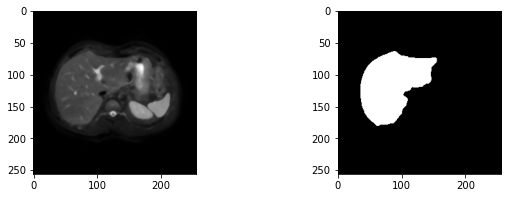

In [6]:
'''
Abs: test transform on dataloader_train.
---
take first image in every batch.
'''
for data in dataloader_train:
    for x, y in zip(*data): 
        print(x.shape, y.shape)
        print(np.histogram(x.numpy()), y.unique())
    
        show_image(x.squeeze(0).numpy(), y.squeeze(0).numpy())
        break
    break

In [7]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.ops import sigmoid_focal_loss

class unetModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.encoder = model
#         self.decoder = decoder

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        outputs = self.encoder(x)

        loss = sigmoid_focal_loss(outputs, y, reduction='sum')
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def forward(self, x):
        return self.encoder(x)

In [8]:
'''
title: create model
---
補充:
- 要在建立optimizer之前就把model的參數移到gpu裡面(也就是在把參數託管給optim以前)
ref: 
- https://pytorch.org/docs/stable/optim.html 
- Road Extraction by Deep Residual U-Net, 2017
- U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015
- Attention U-Net: Learning Where to Look for the Pancreas, 2018
'''
 
# model = UNet
# model = ResUnet # suggest: only use it for single channel outputs, Sigmoid activation, Dice loss or focal loss
model = AttUnet # better ResUnet 
model = model((WIDTH, HEIGHT), in_ch=1, out_ch=1, activation=None).to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-1)

In [9]:
'''
abs: training model
---
- 下面的程序會在3種條件下儲存當前的model(只包含weight)
    - 當前模型的loss是目前以來最低
    - 當前epoch數是20的倍數
    - 完成一個epoch的訓練
'''
from torchvision.ops import sigmoid_focal_loss

EPOCHS = 100
min_target_loss_value = float("inf") 
save_root = './data/save_weights/'
os.makedirs(save_root, exist_ok=True)

for epoch in range(EPOCHS):  
    class_loss_value = 0.0
    if epoch < 5:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-5
    elif epoch == 5:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-2
    
            
            
    for i, (source_data, source_label) in enumerate(dataloader_train):
        # zero the parameter gradients
        '''
        abs: zero the parameter gradients
        ---
        這兩種方法都能夠清除variable內的gradient:
        方法1
        param in model.parameters():
        param.grad = None
        方法2 借助optimizer尋找關聯的variable並清除gradient
        optimizer.zero_grad()
        '''
        optimizer.zero_grad()
    
        source_data = source_data.to(device)
        source_label = source_label.to(device)
        
        outputs = model(source_data)
        '''
        abs: single channel'
        ---
        Note:
        - If DiceLloss, outputs = F.sigmoid(outputs)
        - If BCEWithLogitsLoss, outputs不須activation
        '''
#         
#         loss = DiceLoss()(outputs, source_label)
#         loss = torch.nn.MSELoss()(outputs, source_label)
#         loss = torch.nn.BCEWithLogitsLoss(pos_weight = torch.Tensor([100]).to(device))(outputs, source_label)
        loss = sigmoid_focal_loss(outputs, source_label, reduction='sum')
        
        '''
        title: multi channel
        ---
        Note:
        - If CrossEntropyLoss, source_label should be as channel as outputs. ex: (B, C, W, H)
        - if FocalLoss, source_label should be 1 channel, ex: (B, 1, W, H)
        '''
#         loss = nn.CrossEntropyLoss()(outputs, source_label.long())
#         loss = FocalLoss(alpha=[0.05,0.1,1], gamma=1, size_average=False)(outputs, source_label.long())
        
    
        class_loss_value += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(i, end='\r')
        del source_data, source_label, outputs
        torch.cuda.empty_cache()

    class_loss_value /= (i+1)   
    testing_loss_value = class_loss_value

    print(f'epoch: {epoch}, class_loss_value:{class_loss_value}')
    if testing_loss_value < min_target_loss_value:
        min_target_loss_value = testing_loss_value
        print('save best model')
        torch.save(model.state_dict(), f'{save_root}best_model.bin')
    else:
        if epoch%50==49:
            
            torch.save(model.state_dict(), f'{save_root}E{epoch}_model.bin')
        torch.save(model.state_dict(), f'{save_root}model.bin')
    

epoch: 0, class_loss_value:46736.181640625
save best model


KeyboardInterrupt: 

In [30]:
'from normal pytorch'
model = ResUnet
model = model(HEIGHT, in_ch=1, out_ch=3, activation=None).to(device)
save_root = './data/save_weights/'
filepath = f'{save_root}E299_model.bin'
model.load_state_dict(torch.load(filepath)) 

# 'pytorch-lightning'
# checkpoint = torch.load('data/save_weights/epoch=99_train_loss=775.5070_model.ckpt')
# model = unetModel(model)
# model.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.1885, device='cuda:0')


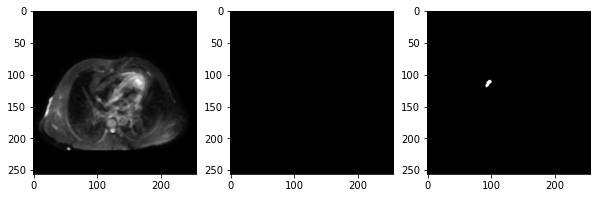

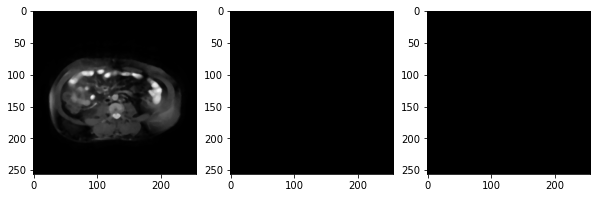

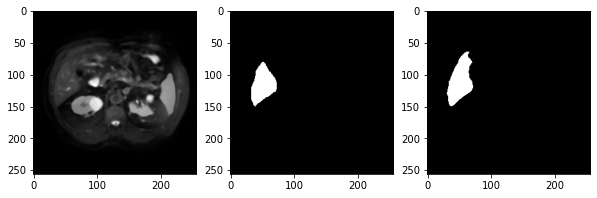

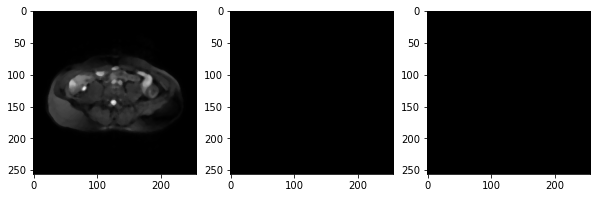

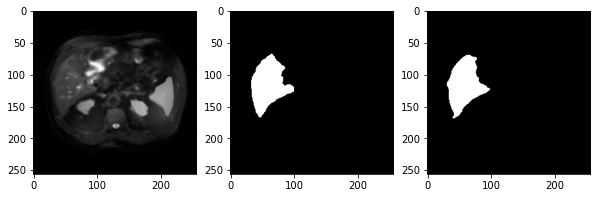

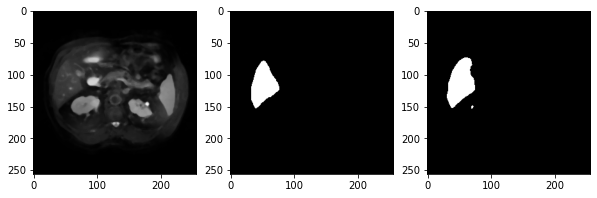

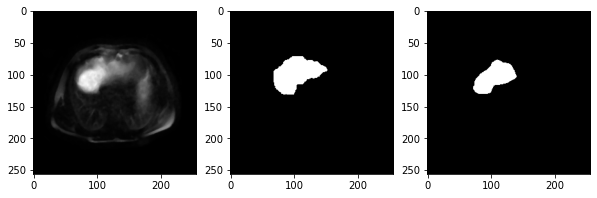

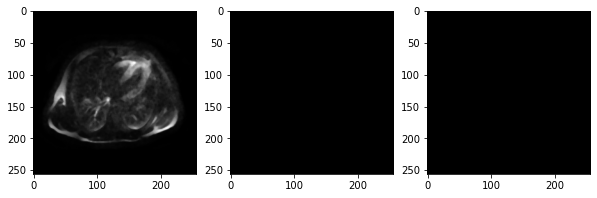

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.1749, device='cuda:0')


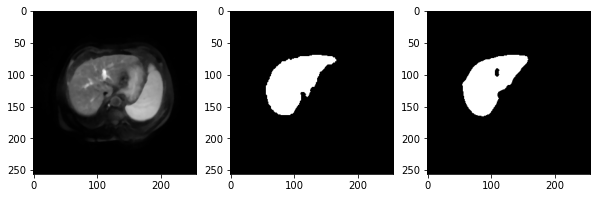

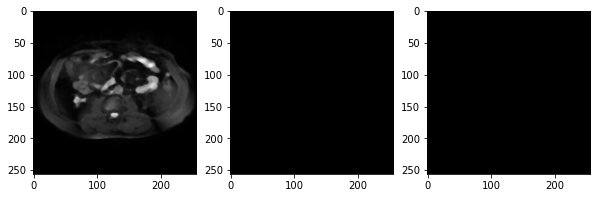

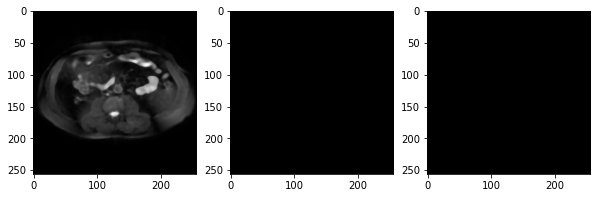

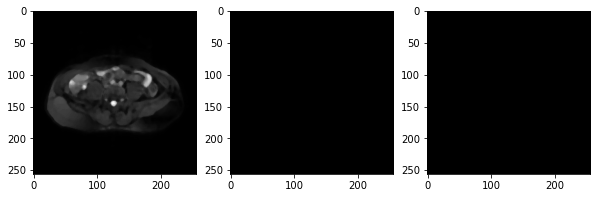

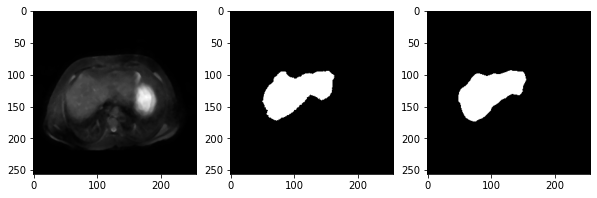

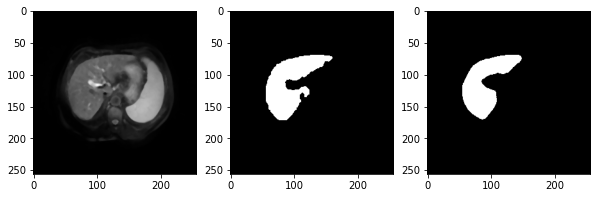

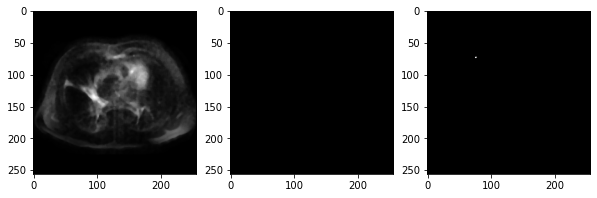

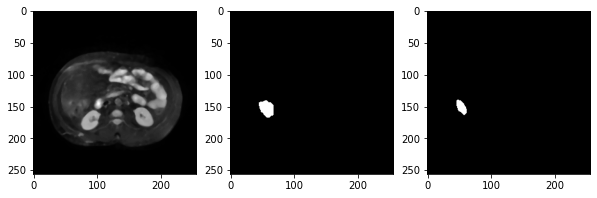

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.1190, device='cuda:0')


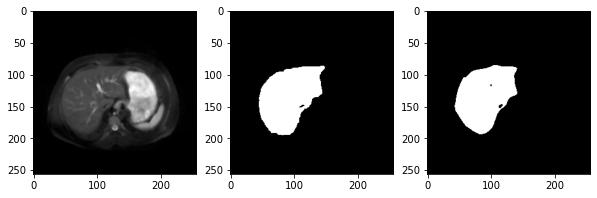

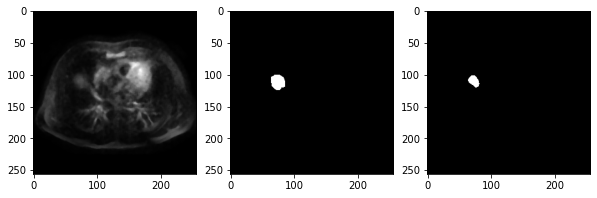

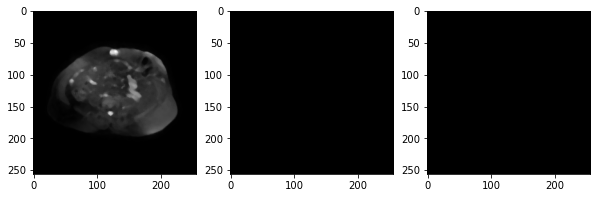

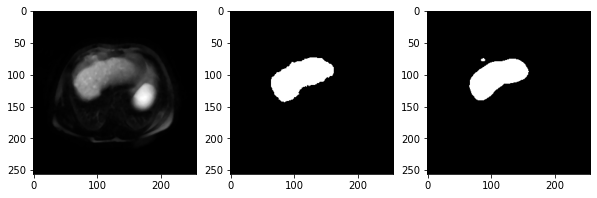

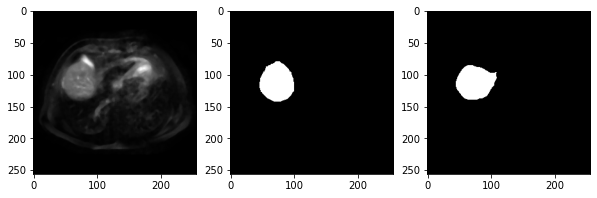

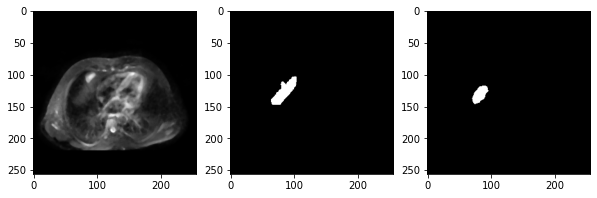

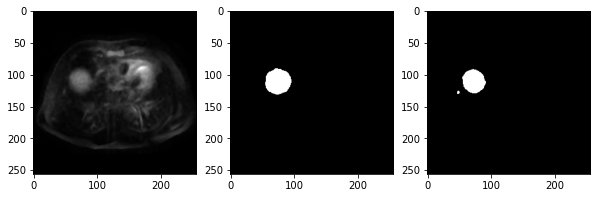

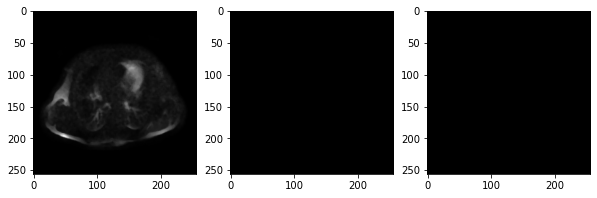

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.0908, device='cuda:0')


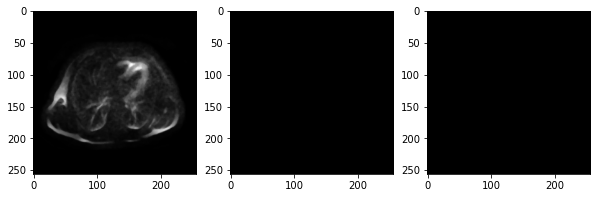

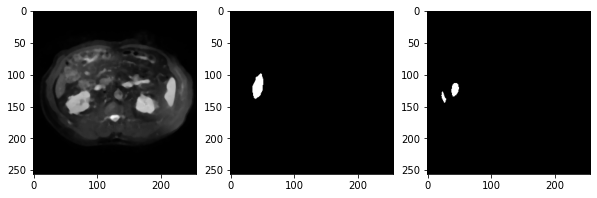

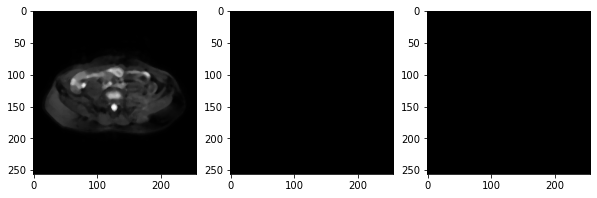

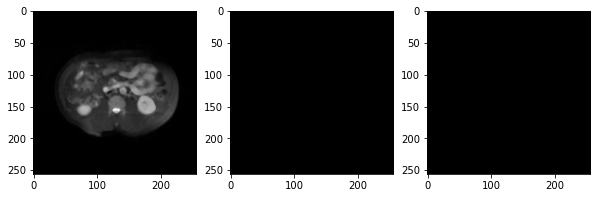

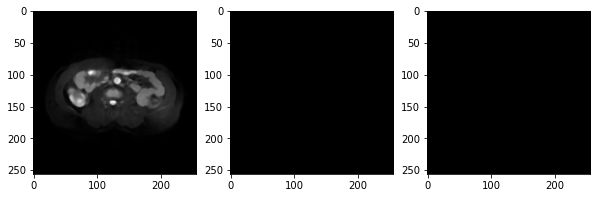

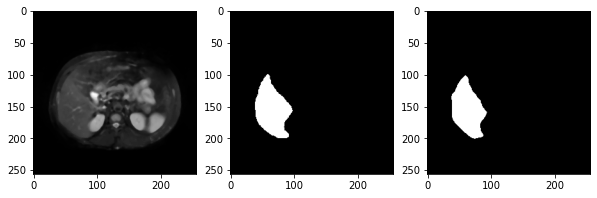

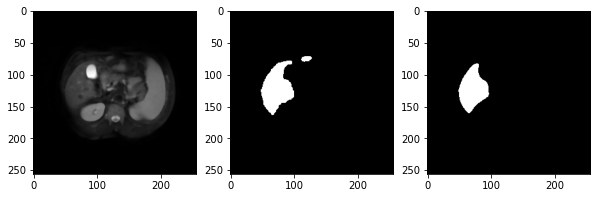

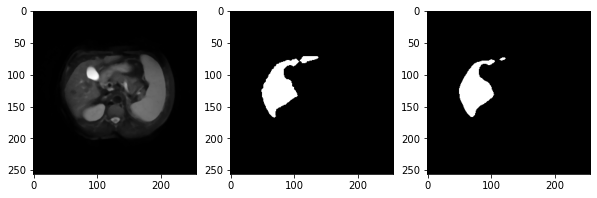

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.1546, device='cuda:0')


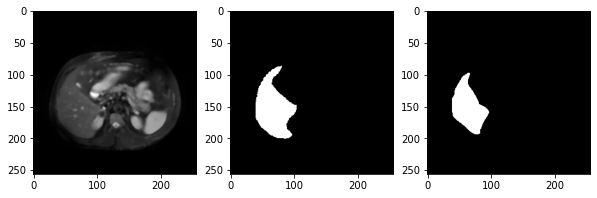

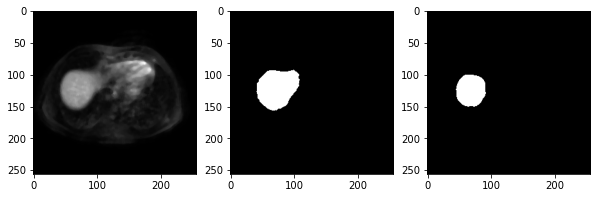

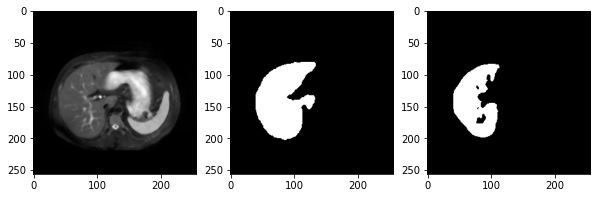

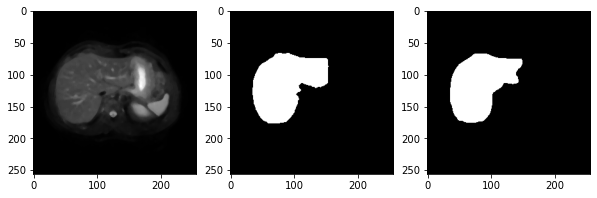

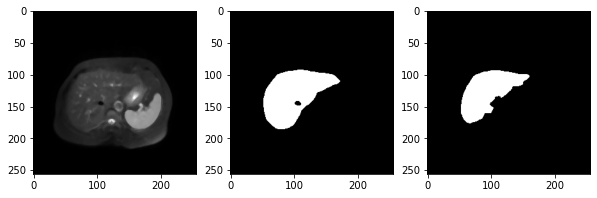

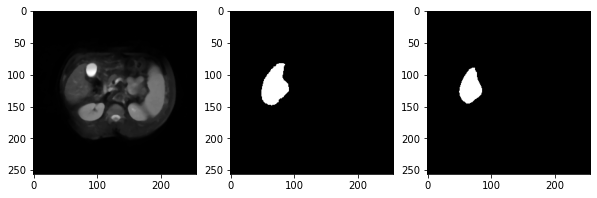

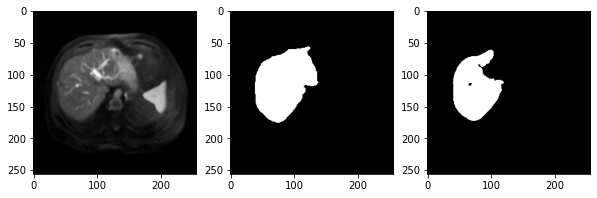

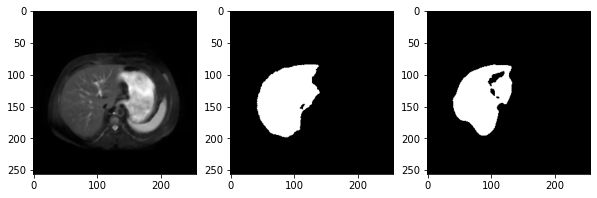

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.0807, device='cuda:0')


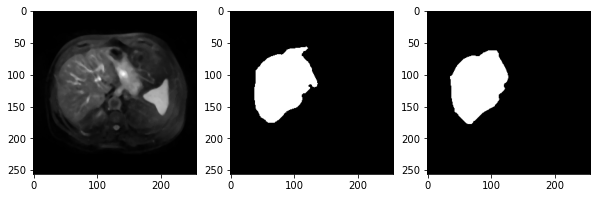

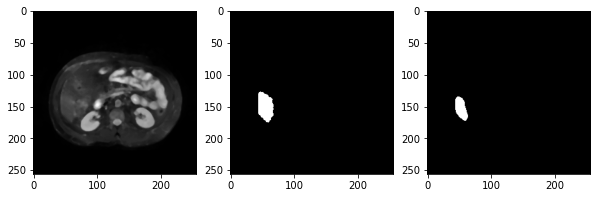

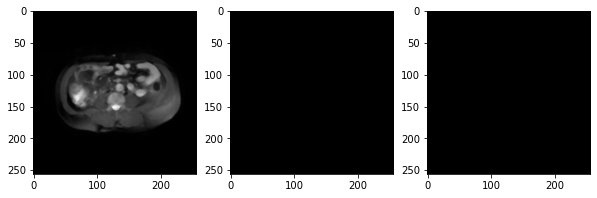

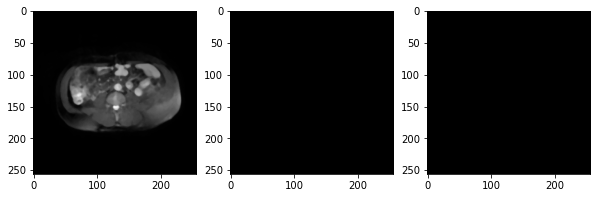

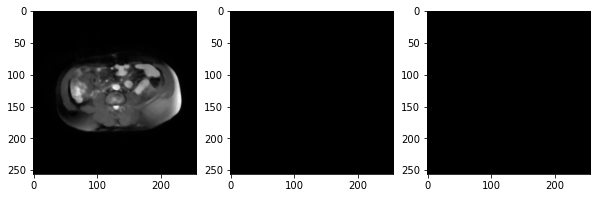

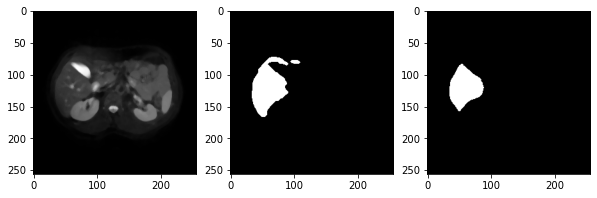

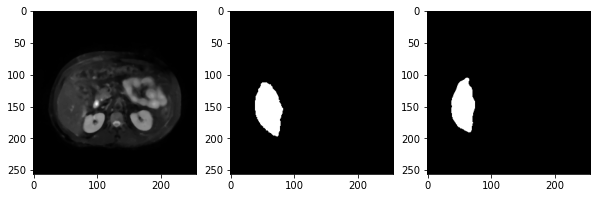

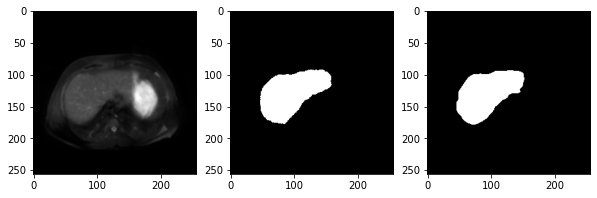

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.2754, device='cuda:0')


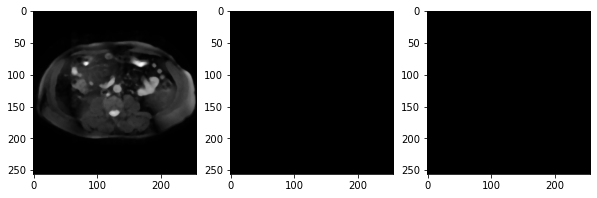

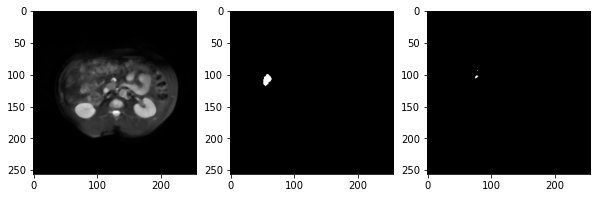

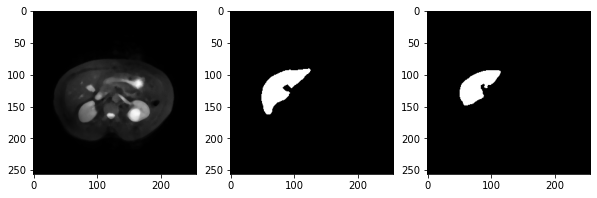

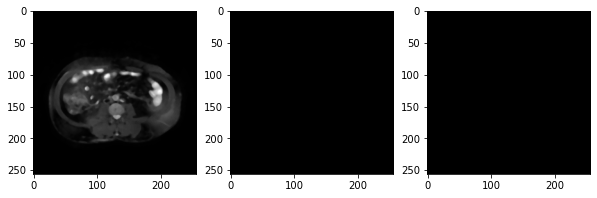

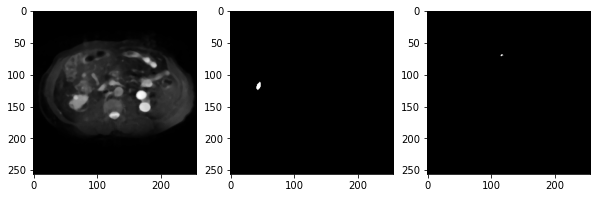

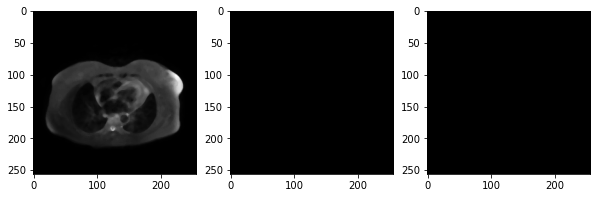

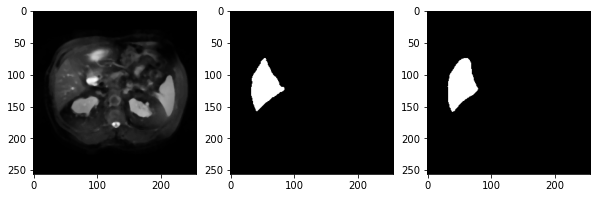

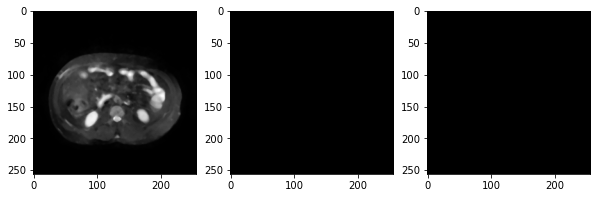

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.1763, device='cuda:0')


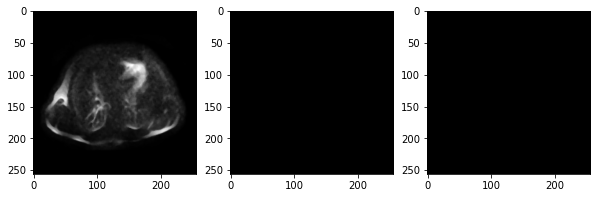

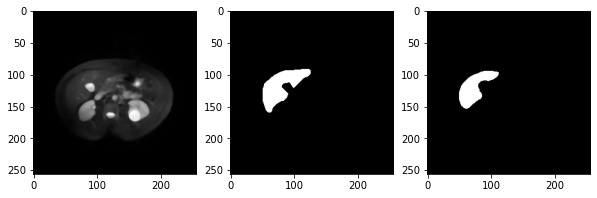

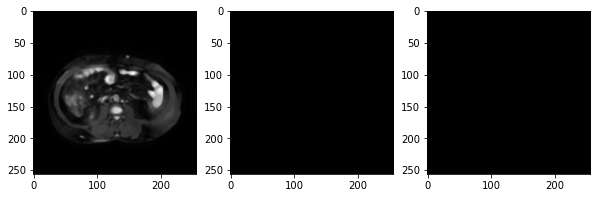

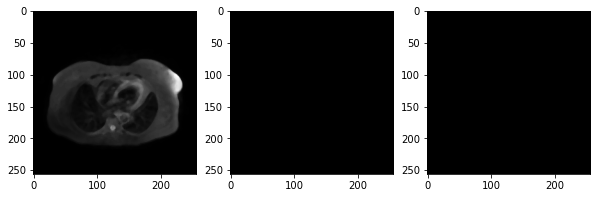

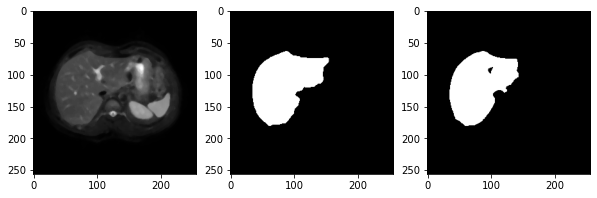

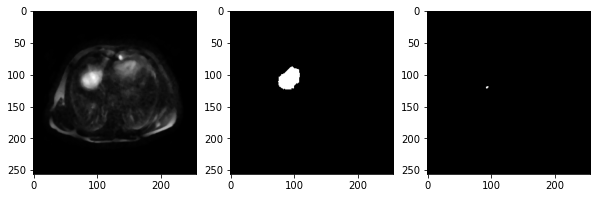

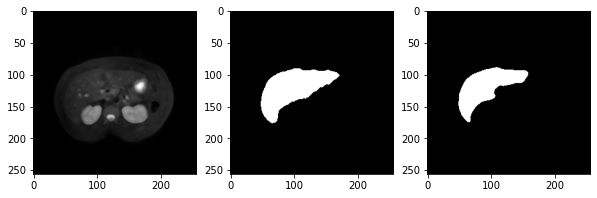

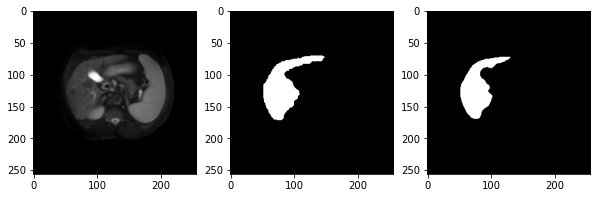

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.1927, device='cuda:0')


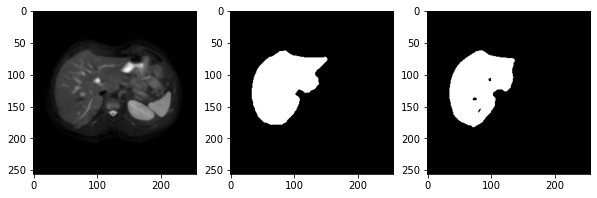

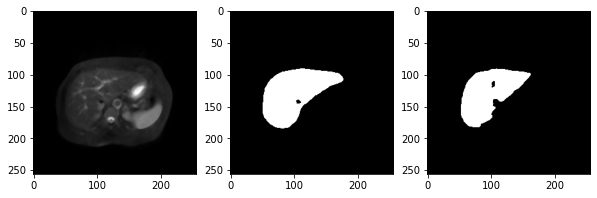

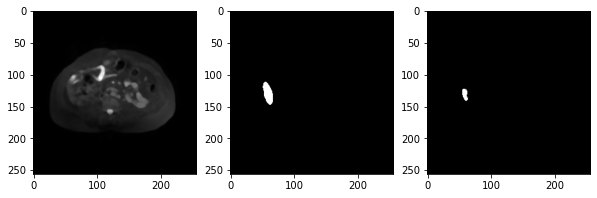

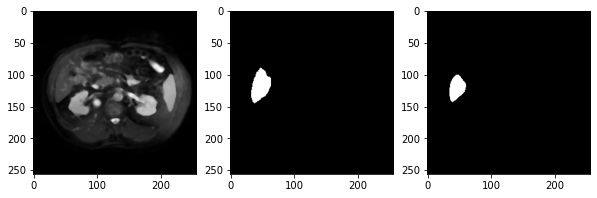

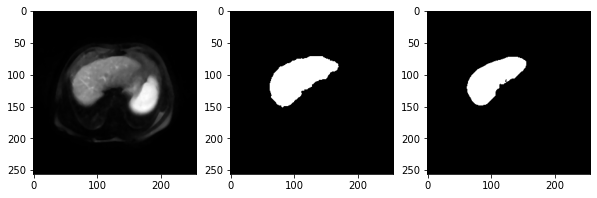

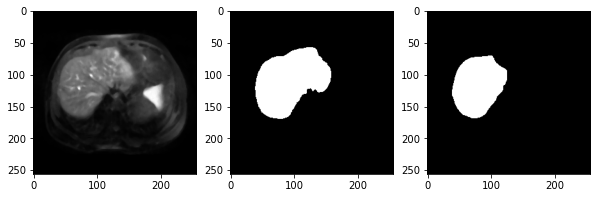

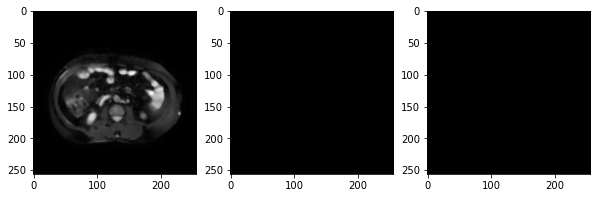

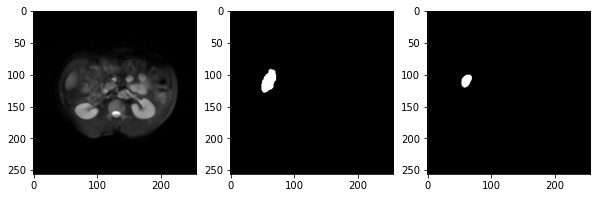

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.1237, device='cuda:0')


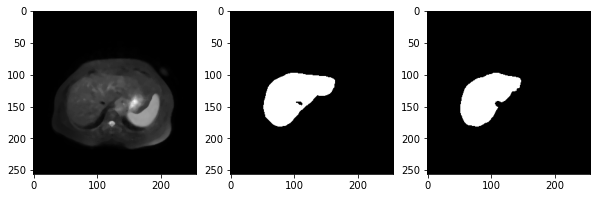

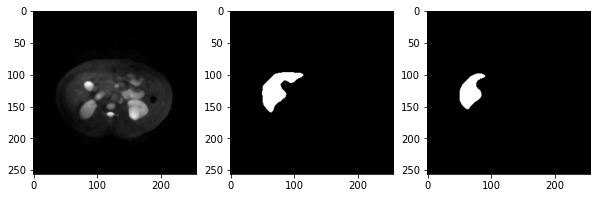

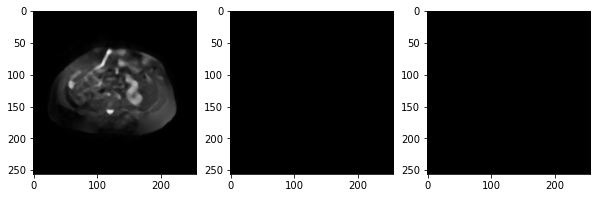

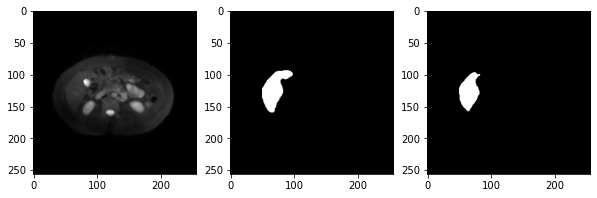

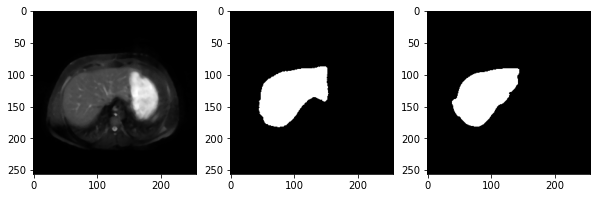

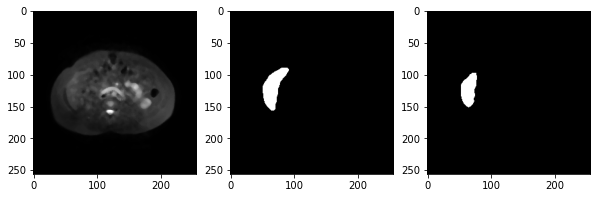

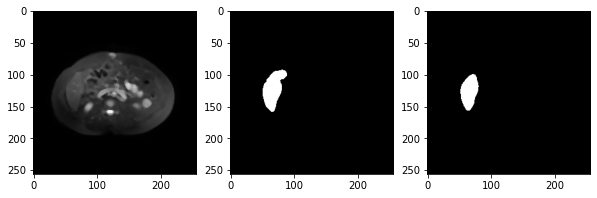

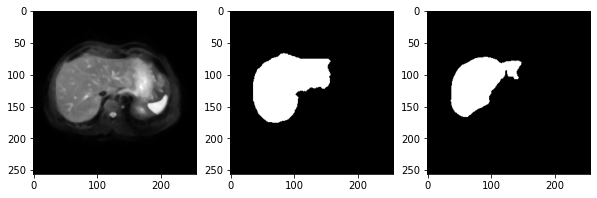

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.0717, device='cuda:0')


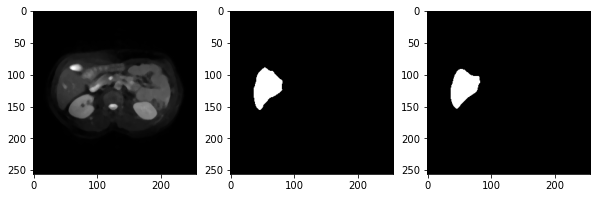

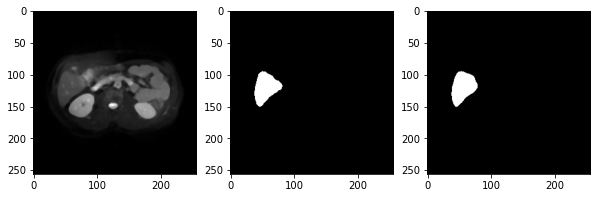

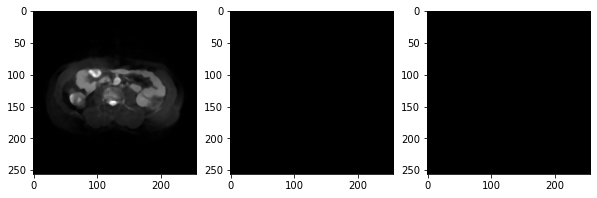

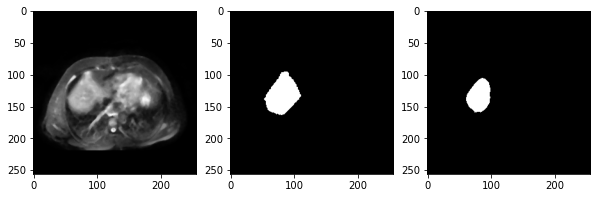

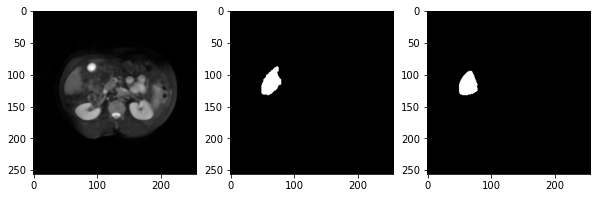

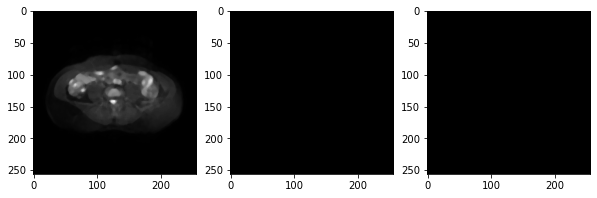

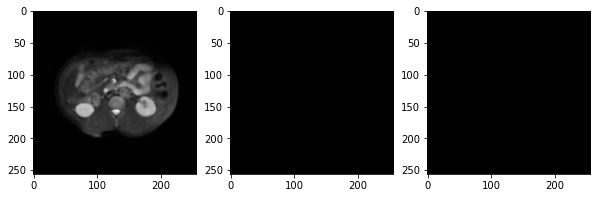

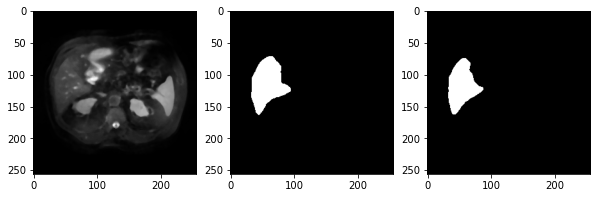

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.2146, device='cuda:0')


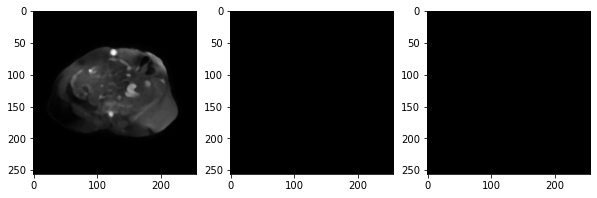

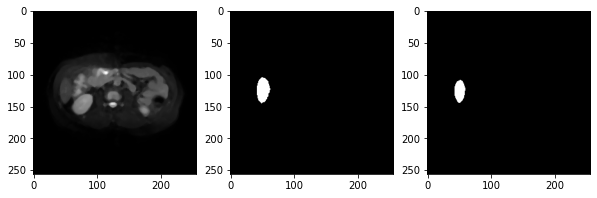

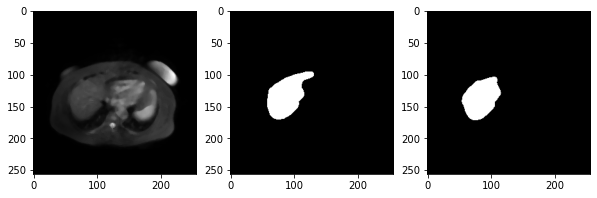

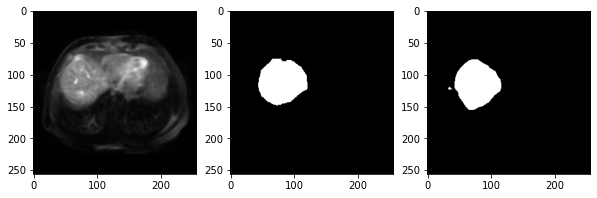

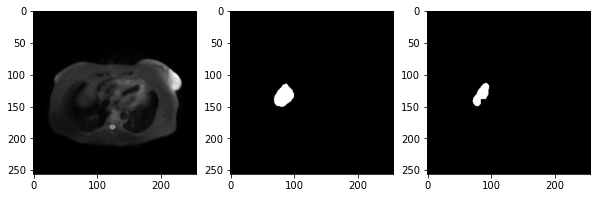

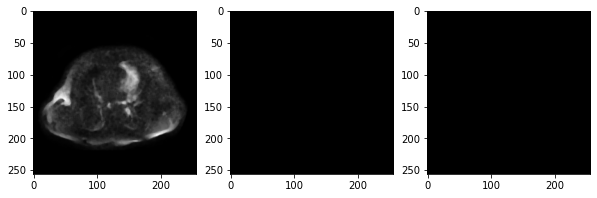

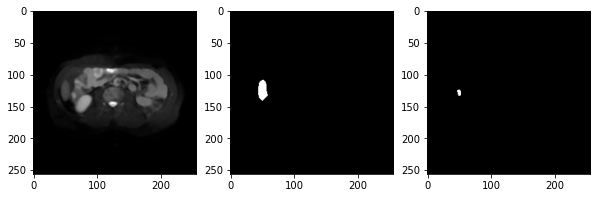

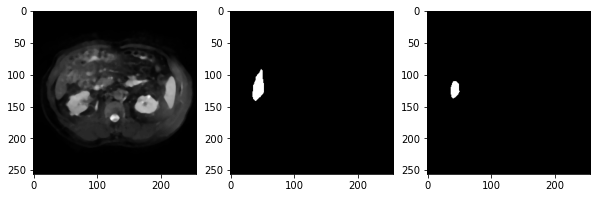

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.3586, device='cuda:0')


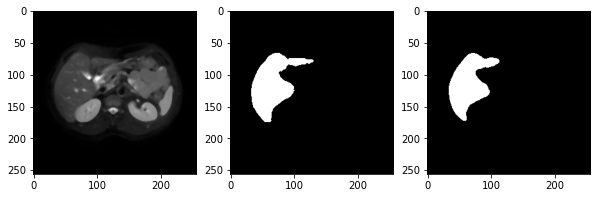

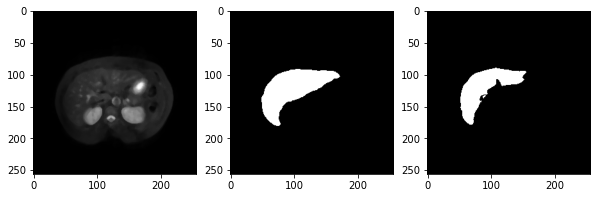

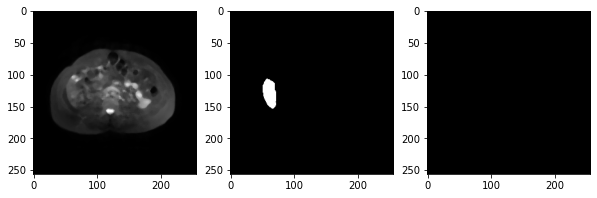

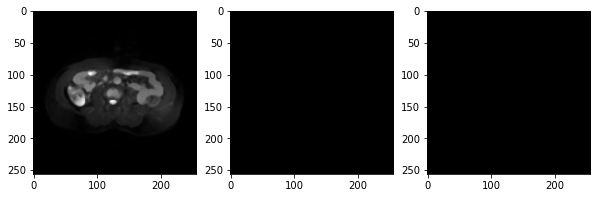

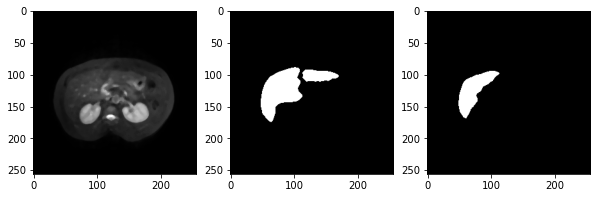

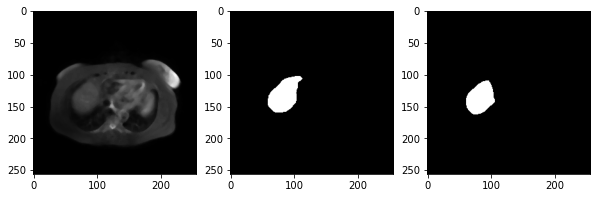

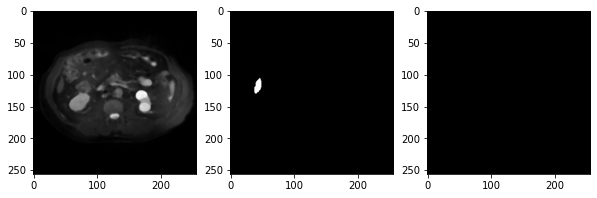

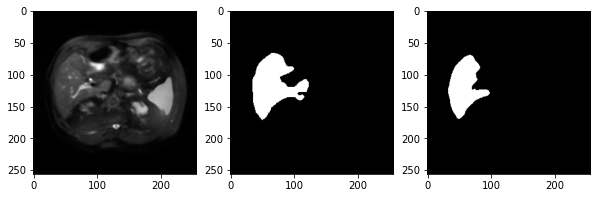

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.0802, device='cuda:0')


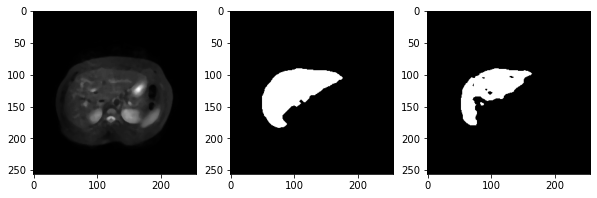

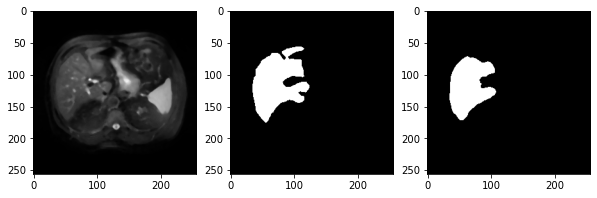

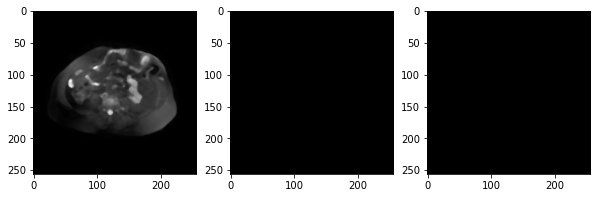

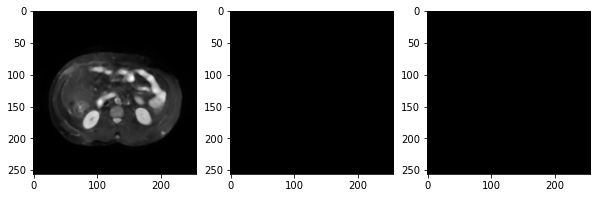

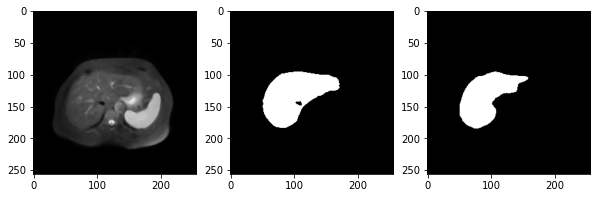

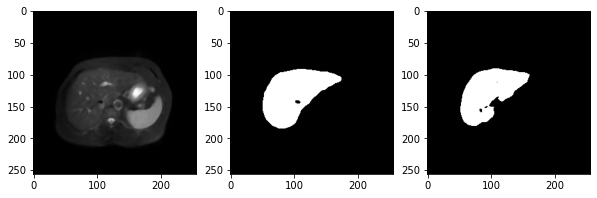

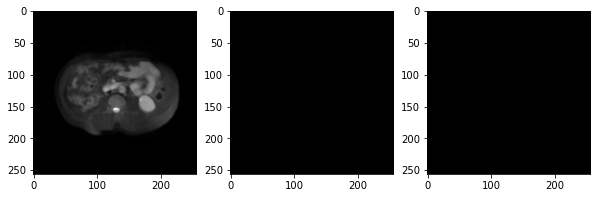

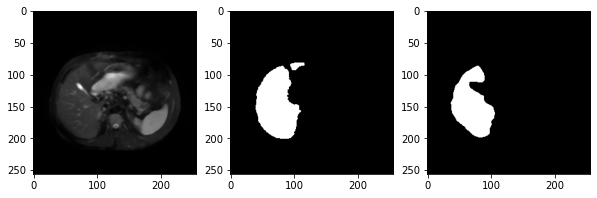

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.2009, device='cuda:0')


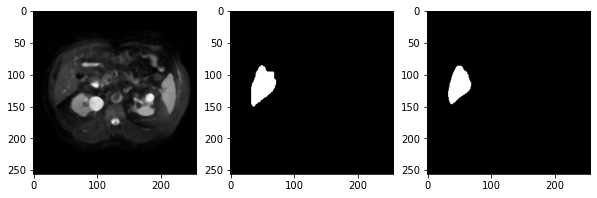

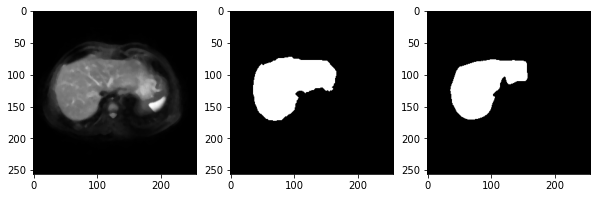

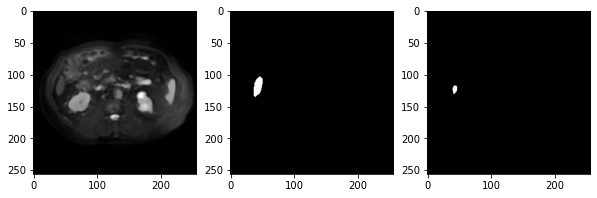

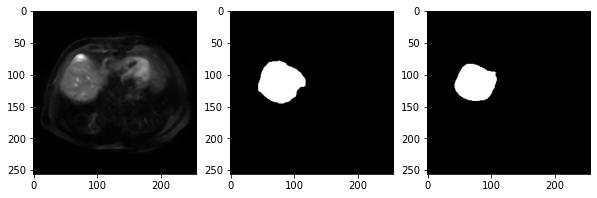

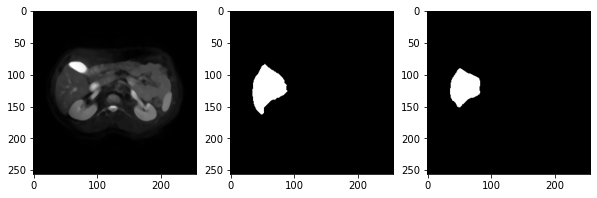

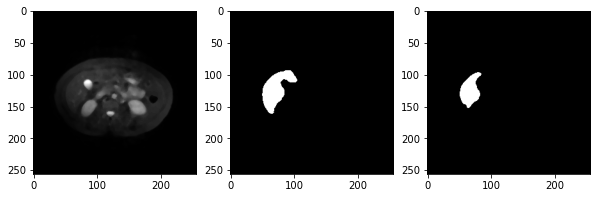

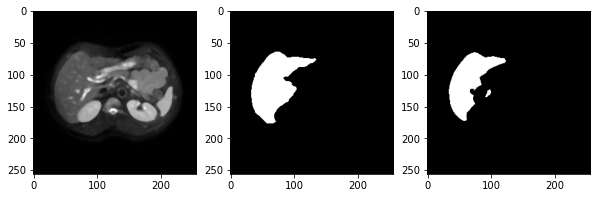

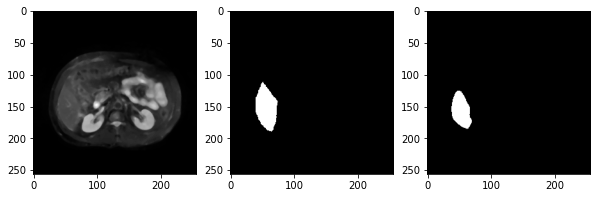

In [31]:
'''
abs: testing model
---
'''

for i, data in enumerate(dataloader_train, 1):
    image, mask = data
    print(len(image), image.shape, mask.shape)
    with torch.no_grad():
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)

    'single channel outputs'
    threshold = 0
    outputs[outputs>=threshold] = 1.
    outputs[outputs!=1] = 0.

    'multi channel outputs'
#     outputs = F.softmax(outputs)
#     outputs = torch.argmax(outputs, dim=1) # with pseudo label
#     outputs = (torch.argmax(outputs, dim=1)==2).int() # only liver segmentation
    
    loss = DiceLoss()(outputs, mask)
    print(loss)
    img_process = lambda image:image.squeeze(1).cpu().numpy()
    mask_process = lambda mask:mask.squeeze(1).cpu().numpy()

    for x, m, outputs in zip(img_process(image), mask_process(mask), mask_process(outputs)):
        show_image(x, m, outputs)
#         break
            
    del outputs, image, mask

In [2]:
# import os
# try:
#     if get_ipython().__class__.__name__=='ZMQInteractiveShell':
#         os.system('jupyter nbconvert train_unet.ipynb --to python')
# except NameError:
#     pass

[NbConvertApp] Converting notebook train_unet.ipynb to python
[NbConvertApp] Writing 9026 bytes to train_unet.py
